# GNN runner
## Mark Tenzer & Jimmy Howerton
## Adapted from code provided with the Spektral package, cited below:
https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py


# Imports

In [1]:
# Base python
import pickle # for loading sparse matrix from disk
import gc     # for garbage collection (RAM management/cleanup)

# Common scientific packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import math

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# TF imports
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Dense, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
# Spektral imports for GNN
from spektral.layers import GraphConv, GraphSageConv, GINConv

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Config

In [3]:
# Type of graph convolution
Conv = GraphConv

# File location to save model
modelfile = "GraphConv-DNN-2015.h5"

# Number of graph convolution layers
n_layers = 5

# Number of channels at each conv
channels = 64

# Adjacency matrix of choice
adj_file = "Aboth.pkl"

# Maximum number of training epochs
epochs = 500

# Dropout rate
# dropout_rate = 0.5

# Read the adjacency matrix $A$

#### Load $A$ from disk

In [4]:
with open(adj_file, 'rb') as f:
    A = pickle.load(f)

#### Preprocess $A$ as needed for this GNN convolution technique

In [5]:
fltr = Conv.preprocess(A.astype('float32'))

# Read the data

#### Initial read of file

In [6]:
data = pd.read_csv('~/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={#'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

#### Drop unnecessary columns

In [7]:
data.drop(['Unnamed: 0.1', 'index_x', 'FOD_ID', 'FIRE_NAME', 'DISCOVERY_DOY_SCALED',
           'x_fire', 'y_fire', 'z_fire',
           'index_y', 'Begin', 'End', 'Country', 'Day', 'ICAO', 'Latitude', 'Longitude', 'Month', 'STATION NAME',
           'State', 'Station', 'USAF', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 
           'WBAN', 'Year', 'doy', 'x', 'y', 'z',
          ],
         axis='columns', inplace=True)

#### Just 2015 data

In [8]:
data = data[data.FIRE_YEAR == 2015]

#### Cleanup memory

In [9]:
gc.collect()

60

# Preprocess the data

Perform imputation as appropriate; split into train/validation sets.

#### Split into features and labels

In [10]:
Y = pd.get_dummies(data['STAT_CAUSE_DESCR'])
X = pd.get_dummies(data.drop('STAT_CAUSE_DESCR', axis='columns'))

# Number of examples
N = X.shape[0]
# Number of features
F = X.shape[1]

#### Find the missing values, and set to NA

In [11]:
for na in [9999.9, 999.9, 99.99]:
    X[X == na] = np.nan

#### Zero-imputing for some features -- see EDA.ipynb

In [12]:
for zcol in ['Gust', 'MaxWindspeed', 'Precip', 'SnowDepth', 'Visibility', 'Windspeed']:
    X.loc[X[zcol].isna(), zcol] = 0

# Split into training/testing

We'll have three sets of nodes: training nodes, validation nodes, and censored nodes (nodes without valid labels).  Note that this is a semi-supervised problem.

#### Determine which nodes lack valid labels

In [13]:
# Determing which fires fit in these categories
censor = (data['STAT_CAUSE_DESCR'] == 'Missing/Undefined') | (data['STAT_CAUSE_DESCR'] == 'Miscellaneous')

# Drop these levels from the label
Y = Y.drop(['Missing/Undefined', 'Miscellaneous'], axis='columns').values

# Number of classes left
n_classes = Y.shape[1]

In [14]:
labeled_ind  = np.arange(data.shape[0])[~censor]
censor_ind = np.arange(data.shape[0])[censor ]

#### Determine which nodes lack valid labels

In [15]:
train_ind, val_ind = train_test_split(labeled_ind, test_size=0.1, random_state=42)

# "Masks" for training and validation: 1 if in the given set, 0 if not (or no label)
train_mask = np.zeros(N)
train_mask[train_ind] = 1

val_mask = np.zeros(N)
val_mask[val_ind] = 1

#### Mean imputation for the other features -- see EDA.ipynb

In [16]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [17]:
# Make sure to fit only on the training data!  Otherwise the imputation introduces bias
imp.fit(X.values[train_ind, :])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [18]:
# Impute the training and testing values
X = imp.transform(X)

# Define the model

### Model definition

GIN: add "mlp_hidden=\[64\]" parameter to the Conv definition

GraphSAGE: add "aggregate_op = 'max'" parameter to the Conv definition

In [19]:
# Input
X_in = Input(shape=(F, ))           # features  for this node
fltr_in = Input((N, ), sparse=True) # adjacency for this node

currentX = X_in

# For each of the specified layers,
for _ in range(n_layers):

    # Dropout the current layer's inputs
    #currentX = Dropout(dropout_rate)(currentX)
    
    # Graph convolution -- Note that "Conv" type was specified in Config section
    currentX = Conv(channels,
                      activation='relu',
                      #kernel_regularizer=l2(0.1),
                      #use_bias=False
                     )([currentX, fltr_in])
    
    #currentX = BatchNormalization()(currentX)

# Dense Neural Network

print(currentX.shape)

for _ in range(3):
    #currentX = Dropout(dropout_rate)(currentX)

    currentX = Dense(64, activation='relu')(currentX)
    #currentX = BatchNormalization()(currentX)
    #currentX = Activation('relu')(currentX)
    
# Final layer
output = Dense(Y.shape[1], activation='softmax')(currentX)

(None, 64)


### Model setup

Learning Rate Decay: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

This is only recommended for GIN models

In [20]:
# def step_decay(epoch):
#    initial_lrate = 1e-2
#    drop = 0.5
#    epochs_drop = 50.0
#    lrate = initial_lrate * math.pow(drop,  
#            math.floor((1+epoch)/epochs_drop))
#    return lrate

In [21]:
# class LossHistory(Callback):
#     def on_train_begin(self, logs={}):
#        self.losses = []
#        self.lr = []
 
#     def on_epoch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        self.lr.append(step_decay(len(self.losses)))

In [22]:
callbacks_list = [EarlyStopping(patience=50,  restore_best_weights=True)]
# loss_history = LossHistory()
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [loss_history, lrate, EarlyStopping(patience=50,  restore_best_weights=True)]

In [23]:
# Build model
model = Model(inputs=[X_in, fltr_in], outputs=output)
model.compile(optimizer=Adam(1e-2),
              loss='categorical_crossentropy',
              weighted_metrics=['categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
gin_conv (GINConv)              (None, 64)           9537        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
gin_conv_1 (GINConv)            (None, 64)           8321        gin_conv[0][0]               

# Model fitting

In [24]:
# Define validation data
validation_data = ([X, fltr], Y, val_mask)

history = model.fit([X, fltr],
          Y,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,  # Shuffling data means shuffling the whole graph
          callbacks=callbacks_list)

l_loss: 6670.4390 - val_categorical_accuracy: 0.3355
Epoch 392/500
74491/74491 [==============================] - 1s 14us/sample - loss: 71962.6406 - categorical_accuracy: 0.3367 - val_loss: 6618.9297 - val_categorical_accuracy: 0.3351
Epoch 393/500
74491/74491 [==============================] - 1s 14us/sample - loss: 71176.2500 - categorical_accuracy: 0.3367 - val_loss: 6759.7622 - val_categorical_accuracy: 0.3297
Epoch 394/500
74491/74491 [==============================] - 1s 14us/sample - loss: 72482.3047 - categorical_accuracy: 0.3279 - val_loss: 6744.7144 - val_categorical_accuracy: 0.3305
Epoch 395/500
74491/74491 [==============================] - 1s 14us/sample - loss: 72274.1797 - categorical_accuracy: 0.3282 - val_loss: 6610.9653 - val_categorical_accuracy: 0.3321
Epoch 396/500
74491/74491 [==============================] - 1s 14us/sample - loss: 71177.0938 - categorical_accuracy: 0.3343 - val_loss: 6629.6680 - val_categorical_accuracy: 0.3349
Epoch 397/500
74491/74491 [=====

# Plot training history

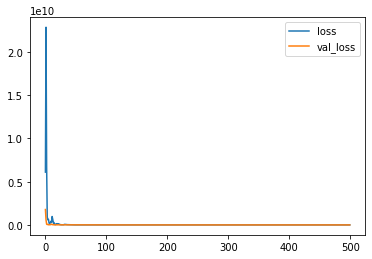

In [25]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
plt.show()

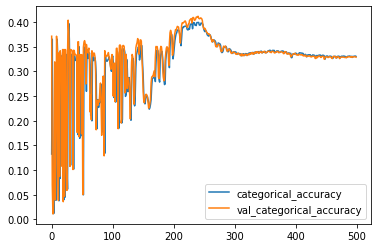

In [26]:
fig, ax = plt.subplots()
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
ax.legend()
plt.show()

# Save model to disk

In [27]:
model.save(modelfile)